### Normal likelihood

$L(\mu,\sigma^2|x_1,...,x_n)= (2\pi\sigma^2)^{(-n/2)}\exp\left(-\dfrac{1}{2\sigma^2}\sum_{j=1}^{n} (x_j-\mu)^2\right)$

ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 


In [ ]:
import math, numpy as np, matplotlib.pyplot as plt

def calc_normal_likelihood(mu,sigma,X):
    n = len(X)
    c1 = (2*np.pi*sigma**2)**(-n/2)
    c2 = -1/(2*sigma**2)
    exp_sum = np.sum(np.square(X-mu))
    L = c1*np.exp(c2*exp_sum)
    return L

In [ ]:
sigma = 0.1
n_data = 2

a = 0.5
b = 1
t = np.linspace(1,10, n_data)
y_true = a*t+b
y_obs = y_true + np.random.normal(0, sigma, len(y_true))

plt.plot(t,y_true)
plt.plot(t,y_obs, 'o')

In [ ]:
a_vals = np.linspace(-1,1,100)
b_vals = np.linspace(-2,2,100)

def f(a, b, sigma, mu, t): 
    X = a*t+b
    L = calc_normal_likelihood(mu,sigma,X)
    return L

a_tmp, b_tmp = np.meshgrid(a_vals,b_vals)
Z = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        Z[i,j] = f(a_tmp[i,j],b_tmp[i,j],sigma,y_obs,t)

plt.pcolor(a_tmp, b_tmp, Z)
plt.show()

### Transporter - 2D model


log-likelihood: ref=-113975.0918464175, grid max=10738.23352767275


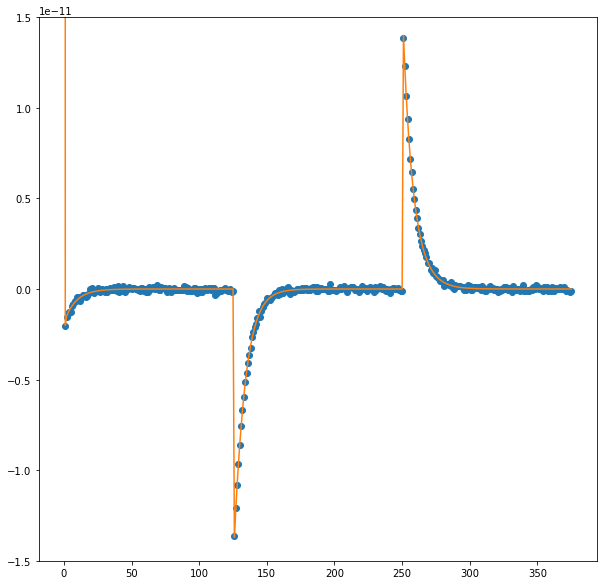

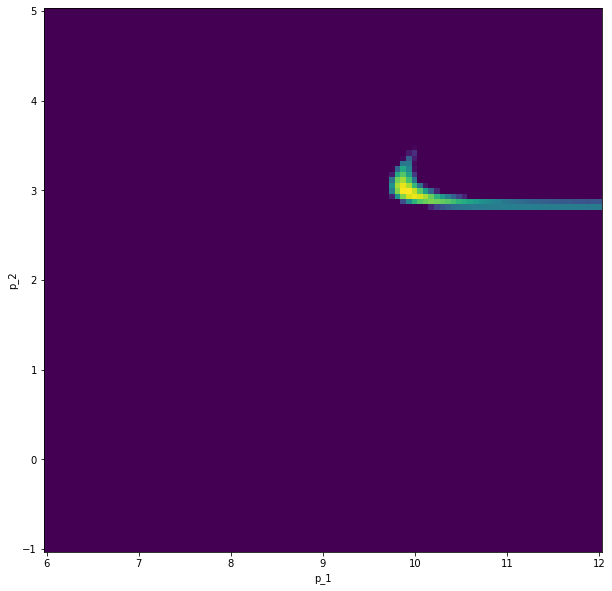

[ 0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4   0.44
  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88  0.92
  0.96  1.    1.04  1.08  1.12  1.16  1.2   1.24  1.28  1.32  1.36  1.4
  1.44  1.48  1.52  1.56  1.6   1.64  1.68  1.72  1.76  1.8   1.84  1.88
  1.92  1.96  2.    2.04  2.08  2.12  2.16  2.2   2.24  2.28  2.32  2.36
  2.4   2.44  2.48  2.52  2.56  2.6   2.64  2.68  2.72  2.76  2.8   2.84
  2.88  2.92  2.96  3.    3.04  3.08  3.12  3.16  3.2   3.24  3.28  3.32
  3.36  3.4   3.44  3.48  3.52  3.56  3.6   3.64  3.68  3.72  3.76  3.8
  3.84  3.88  3.92  3.96  4.    4.04  4.08  4.12  4.16  4.2   4.24  4.28
  4.32  4.36  4.4   4.44  4.48  4.52  4.56  4.6   4.64  4.68  4.72  4.76
  4.8   4.84  4.88  4.92  4.96  5.    5.04  5.08  5.12  5.16  5.2   5.24
  5.28  5.32  5.36  5.4   5.44  5.48  5.52  5.56  5.6   5.64  5.68  5.72
  5.76  5.8   5.84  5.88  5.92  5.96  6.    6.04  6.08  6.12  6.16  6.2
  6.24  6.28  6.32  6.36  6.4   6.44  6.48  6.52  6.56

In [5]:
import numpy as np, tellurium as te, matplotlib.pyplot as plt
import emcee as mc, corner
np.random.seed(10)


# Normal log-likelihood calculation
def calc_norm_log_likelihood(mu,sigma,X):
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = len(X)
    f1 = -1*(n/2)*np.log(2*np.pi*sigma**2)
    f2_a = -1/(2*sigma**2)
    f2_b = 0 
    for i in range(n):
        f2_b += (X[i]-mu[i])**2
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
    return log_likelihood


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


antimony_string = f"""
            // Created by libAntimony v2.12.0
            model transporter_full()

            // Compartments and Species:
            compartment vol;
            species OF in vol, OF_Hb in vol;
            species IF_Hb in vol, IF_Hb_Sb in vol;
            species IF_Sb in vol, OF_Sb in vol;
            species H_in in vol, S_in in vol;
            species $H_out in vol, $S_out in vol;

            // Reactions:
            rxn1: OF + $H_out -> OF_Hb; vol*(k1_f*OF*H_out - k1_r*OF_Hb);
            rxn2: OF_Hb -> IF_Hb; vol*(k2_f*OF_Hb - k2_r*IF_Hb);
            rxn3: IF_Hb + S_in -> IF_Hb_Sb; vol*(k3_f*IF_Hb*S_in - k3_r*IF_Hb_Sb);
            rxn4: IF_Hb_Sb -> IF_Sb + H_in; vol*(k4_f*IF_Hb_Sb - k4_r*IF_Sb*H_in);
            rxn5: IF_Sb -> OF_Sb; vol*(k5_f*IF_Sb - k5_r*OF_Sb);
            rxn6: OF_Sb -> OF + $S_out; vol*(k6_f*OF_Sb - k6_r*OF*S_out);
            

            // Events:
            E1: at (time >= 5): H_out = H_out_activation, S_out = S_out_activation;
            E2: at (time >= 10): H_out = 1e-7, S_out = 0.001;

            // Species initializations:
            H_out = 1e-07;
            H_out has substance_per_volume;

            H_in = 1e-7;
            H_in has substance_per_volume;

            S_out = 0.001;
            S_out has substance_per_volume;

            S_in = 1e-3;
            S_in has substance_per_volume;

            OF = 2.833e-8;
            OF has substance_per_volume;

            OF_Hb = 2.833e-8;
            OF_Hb has substance_per_volume;

            IF_Hb = 2.833e-8;
            IF_Hb has substance_per_volume;
            
            IF_Hb_Sb = 2.833e-8;
            IF_Hb_Sb has substance_per_volume;
            
            IF_Sb = 2.125e-08;
            IF_Sb has substance_per_volume;

            OF_Sb = 2.125e-08;
            OF_Sb has substance_per_volume;


            // Compartment initializations:
            vol = 0.0001;
            vol has volume;

            // Variable initializations:
            H_out_activation = 5e-8;
            S_out_activation = 0.001;

            // Rate constant initializations:
            k1_f = 1e10;
            k1_r = 1e3;
            k2_f = 1e2;
            k2_r = 1e2;
            k3_f = 1e7;
            k3_r = 1e3;
            k4_f = 1e3;
            k4_r = 1e10;
            k5_f = 1e2;
            k5_r = 1e2;
            k6_f = 1e3;
            k6_r = 1e7;


            // Other declarations:
            const vol;
            const k1_f, k1_r, k2_f, k2_r, k3_f, k3_r;
            const k4_f, k4_r, k5_f, k5_r, k6_f, k6_r;
    

            // Unit definitions:
            unit substance_per_volume = mole / litre;
            unit volume = litre;
            unit length = metre;
            unit area = metre^2;
            unit time_unit = second;
            unit substance = mole;
            unit extent = mole;

            // Display Names:
            time_unit is "time";
            end
            """ 

# p_dict = Dict(
#                 "log_k1_f"=>[6.0,12.0,10.0],
#                 "log_k1_r"=>[-1.0,5.0,3.0],
#                 "log_k2_f"=>[-2.0,4.0,2.0],
#                 "log_k2_r"=>[-2.0,4.0,2.0],
#                 "log_k3_f"=>[3.0,9.0,7.0],
#                 "log_k3_r"=>[-1.0,5.0,3.0],
#                 "log_k4_f"=>[-1.0,5.0,3.0],
#                 "log_k4_r"=>[6.0,12.0,10.0],
#                 "log_k5_f"=>[-2.0,4.0,2.0],
#                 "log_k5_r"=>[-2.0,4.0,2.0],
#                 "log_k6_f"=>[-1.0,5.0,3.0],
#              )


m = te.loada(antimony_string)
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12

D = m.simulate(0, 15, 376, selections=['time', 'rxn4'])
y_true = D['rxn4']

noise_stdev_true = 1e-13
#y_obs = y_true + np.random.normal(0, noise_stdev_true, len(y_true))
y_obs = np.genfromtxt("data_grid_test3.csv", skip_header=1)

plt.figure(figsize=(10,10))
plt.plot(y_obs, 'o')
plt.plot(y_true)
plt.ylim(-1.5e-11, 1.5e-11)

log_like_ref = calc_grid_point([7,3],y_obs,m)

n_grid = 100

a_vals = np.linspace(6,12,n_grid)
b_vals = np.linspace(-1,5,n_grid)


a_tmp, b_tmp = np.meshgrid(a_vals,b_vals)
Z = np.zeros((n_grid,n_grid))
log_like_max = np.NINF

for i in range(n_grid):
    for j in range(n_grid):
        K = [a_tmp[i,j],b_tmp[i,j]]
        Z[i,j] = calc_grid_point(K,y_obs,m)
        #print(K[0],K[1],Z[i,j])
        if Z[i,j] > log_like_max:
            log_like_max = Z[i,j]

print(f'log-likelihood: ref={log_like_ref}, grid max={log_like_max}')
plt.figure(figsize=(10,10))                    
plt.pcolor(a_tmp, b_tmp, Z, shading='auto', vmin=log_like_max-20, vmax=log_like_max)

plt.xlabel('p_1')
plt.ylabel('p_2')
plt.show()

x_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
print(x_tmp['time'])

In [ ]:
import time


def log_likelihood(theta, y_obs, extra_parameters):
    '''log of Guassian likelihood distribution'''
    sigma = 10**theta[0]
    K=theta[1:]
    m = extra_parameters[0] 
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k2_f = 10**K[2]
    m.k2_r = 10**K[3]
    m.k3_f = 10**K[4]
    m.k3_r = 10**K[5]
    m.k4_f = 10**K[6]
    m.k4_r = 10**K[7]
    m.k5_f = 10**K[8]
    m.k5_r = 10**K[9]
    m.k6_f = 10**K[10]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)

    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


def log_prior(theta):
    '''log of uniform prior distribution'''
    p0 = theta[0]
    p1 = theta[1]
    p2 = theta[2]
    p3 = theta[3]
    p4 = theta[4]
    p5 = theta[5]
    p6 = theta[6]
    p7 = theta[7]
    p8 = theta[8]
    p9 = theta[9]
    p10 = theta[10]
    p11 = theta[11]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if (np.log10(5e-14)<p0<np.log10(5e-13)) and (6<p1<12) and (-1<p2<5) and (-2<p3<4) and (-2<p4<4) and \
        (3<p5<9) and (-1<p6<5) and (-1<p7<5) and (6<p8<12) and (-2<p9<4) and (-2<p10<4) and (-1<p11<5):
        return 0  
    else:
        return -np.inf


def log_probability(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf  # ~zero probability
    return logp + log_likelihood(theta, y_obs, extra_parameters)  # log posterior ~ log likelihood + log prior


def set_p0():
#     log_noise_sigma = np.random.uniform(np.log10(5e-14), np.log10(5e-13))
#     log_k1_f = np.random.uniform(6, 12) # log10 rate constant (ref=1e10)
#     log_k1_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
#     log_k2_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
#     log_k2_r = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)

#     log_k3_f = np.random.uniform(3,9)  # log10 rate constant (ref=1e7) 
#     log_k3_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
#     log_k4_f = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
#     log_k4_r = np.random.uniform(6, 12)  # log10 rate constant (ref=1e10)
#     log_k5_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
#     log_k5_r = np.random.uniform(-2,4)   # log10 rate constant (ref=1e2)
#     log_k6_f = np.random.uniform(-1,5)  # log10  rate constant (ref=1e3)
    
    log_noise_sigma = np.random.uniform(np.log10(0.99e-13), np.log10(1.01e-13))
    log_k1_f = np.random.uniform(9.99, 10.01) # log10 rate constant (ref=1e10)
    log_k1_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3)
    log_k2_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
    log_k2_r = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
    log_k3_f = np.random.uniform(6.99, 7.01)  # log10 rate constant (ref=1e7) 
    log_k3_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
    log_k4_f = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
    log_k4_r = np.random.uniform(9.99, 10.01)  # log10 rate constant (ref=1e10)
    log_k5_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
    log_k5_r = np.random.uniform(1.99, 2.01)   # log10 rate constant (ref=1e2)
    log_k6_f = np.random.uniform(2.99, 3.01)  # log10  rate constant (ref=1e3)
    
    p0_list_tmp = [
                log_noise_sigma ,
                log_k1_f ,
                log_k1_r ,
                log_k2_f ,
                log_k2_r ,
                log_k3_f , 
                log_k3_r ,
                log_k4_f ,
                log_k4_r ,
                log_k5_f ,
                log_k5_r ,
                log_k6_f ,
    ]

    return p0_list_tmp



extra_parameters = [m]
n_steps = 10000
n_walkers = 1000
n_dim = 12
pos_list = []
for i in range(n_walkers):
    p0_list_tmp = set_p0()
    pos_list.append(p0_list_tmp)
start_pos = np.asarray(pos_list)

p_ref = [-13,10,3,2,2,7,3,3,10,2,2,3]

print(f"ref log likelihood: {log_likelihood(p_ref,y_obs,extra_parameters)}")


sampler = mc.EnsembleSampler(n_walkers, n_dim, log_probability,  args=(y_obs, extra_parameters))
t_0 = time.time()
sampler.run_mcmc(start_pos, n_steps)
t_run = time.time() - t_0

print(f"wall clock: {t_run} s")

for i in range(n_dim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

plt.show()
#plt.savefig('p_1d_posterior.png')
# #corner(samples)

ref log likelihood: 10736.513516166175


In [ ]:
for i in range(n_dim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

plt.show()
plt.savefig('p_1d_posterior.png')

In [ ]:
corner.corner(sampler.flatchain[:])
plt.savefig('p_2d_posterior.png')

In [ ]:
fig, axes = plt.subplots(n_dim, figsize=(10, 15), sharex=True)

labels = [
    'log10 sigma',
    'log10 k1_f',
    'log10 k1_r',
    'log10 k2_f',
    'log10 k2_r',
    'log10 k3_f',
    'log10 k3_r',
    'log10 k4_f',
    'log10 k4_r',
    'log10 k5_f',
    'log10 k5_r',
    'log10 k6_f',
]
for i in range(n_dim):
    ax = axes[i]
    for j in range(n_walkers):
        tmp = sampler.flatchain[n_steps*j:n_steps*(j+1),i]
        ax.plot(tmp, "k", alpha=0.3)
    ax.set_xlim(0, len(tmp))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig('p_mcmc_traj.png')

In [ ]:
tau = sampler.get_autocorr_time()
print(f'n_steps/50 = {n_steps/50}, autocorrelation = {tau}')
print(tau)


10724.502268279683
8697.490026177835
7564.633275546291
11497569.953977358
1.4000000000000001 1.4
1.6400000000000001 1.64
1.8800000000000001 1.88
2.2800000000000002 2.28
2.7600000000000002 2.76
2.8000000000000003 2.8
3.2800000000000002 3.28
3.3200000000000003 3.32
3.7600000000000002 3.76
3.8000000000000003 3.8
4.5200000000000005 4.52
4.5600000000000005 4.56
4.6000000000000005 4.6
5.5200000000000005 5.52
5.5600000000000005 5.56
5.6000000000000005 5.6
6.5200000000000005 6.52
6.5600000000000005 6.56
6.6000000000000005 6.6
6.640000000000001 6.64
7.5200000000000005 7.52
7.5600000000000005 7.56
7.6000000000000005 7.6
7.640000000000001 7.64
8.040000000000001 8.04
8.120000000000001 8.12
9.040000000000001 9.04
9.120000000000001 9.12
9.200000000000001 9.2
10.040000000000001 10.04
10.120000000000001 10.12
10.200000000000001 10.2
11.040000000000001 11.04
11.120000000000001 11.12
11.200000000000001 11.2
12.040000000000001 12.04
12.120000000000001 12.12
12.200000000000001 12.2
12.280000000000001 12.2

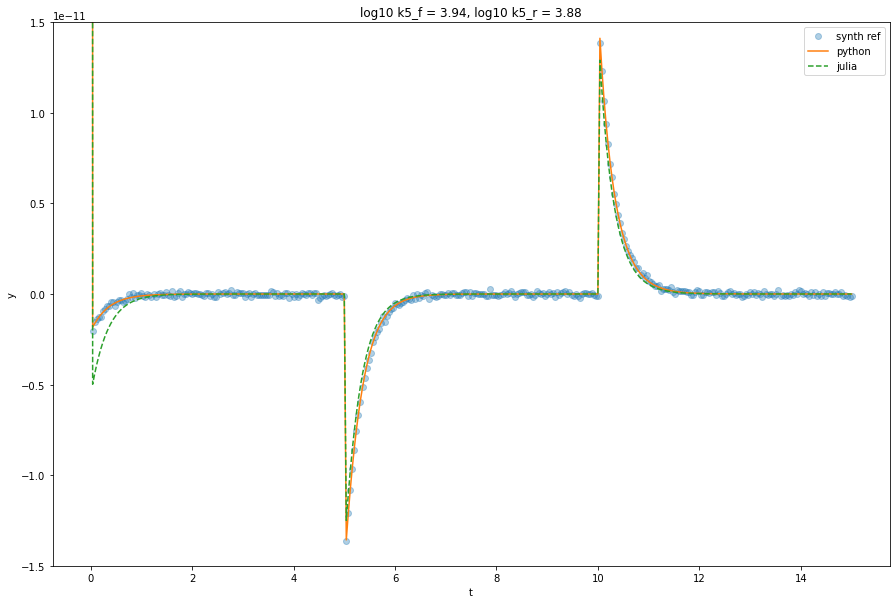

In [24]:
#K = [10.06060606060606, 3.545454545454546]

K = [3.9393939393939394, 3.878787878787879]

print(calc_grid_point(K,y_obs,m))

m.resetToOrigin()
m.H_out_activation = 5e-8
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12
m.k5_f = 10**K[0]
m.k5_r = 10**K[1]
m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
print(m.k5_f)
print(m.k5_r)
print(m.k6_r)
populations = ['time', 
               'rxn4', 
               'H_in',
               'S_in',
               'OF',
               'OF_Hb',
               'IF_Hb',
               'IF_Hb_Sb',
               'IF_Sb',
               'OF_Sb',
              ]
D_tmp = m.simulate(0,15, 376, selections=populations)
y_tmp = D_tmp['rxn4']
t_tmp = D_tmp['time']
sigma = 1e-13
log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)

D_tmp2 = np.transpose(np.genfromtxt("data_y_tmp.csv", skip_header=1,delimiter=','))

y_tmp2 = D_tmp2[0]
t_tmp2 = D_tmp2[1]

for i, t_i in enumerate(t_tmp):
    if t_i != t_tmp2[i]:
        print(f"{t_i} {t_tmp2[i]}")

plt.figure(figsize=(15,10))
plt.plot(t_tmp2, y_obs,'o', alpha=0.35, label='synth ref')
plt.plot(t_tmp, y_tmp, label='python')
plt.plot(t_tmp2, y_tmp2, '--', label='julia')
plt.ylim(-1.5e-11, 1.5e-11)
plt.ylabel('y')
plt.xlabel('t')
plt.title('log10 k5_f = 3.94, log10 k5_r = 3.88')
plt.legend()


print(log_like_tmp)



# print(D_tmp["H_in"][0:2])
# print(D_tmp["S_in"][0:2])
# print(D_tmp["OF"][0:2])
# print(D_tmp["OF_Hb"][0:2])
# print(D_tmp["IF_Hb"][0:2])
print(D_tmp["IF_Hb_Sb"][0:3])
print(D_tmp["IF_Sb"][0:3])
print(D_tmp["H_in"][0:3])

# print(D_tmp["IF_Sb"][0:2])
# print(D_tmp["OF_Sb"][0:2])





In [ ]:
print(te.getODEsFromModel(m))

In [ ]:
H_out_activation = 5e-8;
S_out_activation = 0.001;


H_out = 1e-07;
H_in = 1e-7;
S_out = 0.001;
S_in = 1e-3;

# OF = 2.833e-8;
# OF_Hb = 2.833e-8;
# IF_Hb = 2.833e-8;
# IF_Hb_Sb = 2.833e-8;
# IF_Sb = 2.125e-08;
# OF_Sb = 2.125e-08;

OF = 8;
OF_Hb = 7;
IF_Hb = 6;
IF_Hb_Sb = 5;
IF_Sb = 4;
OF_Sb = 3;

vol = 0.0001;

k1_f = 1e10;
k1_r = 1e3;
k2_f = 1e2;
k2_r = 1e2;
k3_f = 1e7;
k3_r = 1e3;
k4_f = 1e3;
k4_r = 1e10;
k5_f = 1e2;
k5_r = 1e2;
k6_f = 1e3;
k6_r = 1e7;

vrxn1 = vol*(k1_f*OF*H_out-k1_r*OF_Hb)
vrxn2 = vol*(k2_f*OF_Hb-k2_r*IF_Hb)
vrxn3 = vol*(k3_f*IF_Hb*S_in-k3_r*IF_Hb_Sb)
vrxn4 = vol*(k4_f*IF_Hb_Sb-k4_r*IF_Sb*H_in)
vrxn5 = vol*(k5_f*IF_Sb-k5_r*OF_Sb)
vrxn6 = vol*(k6_f*OF_Sb-k6_r*OF*S_out)

dOF_dt = -vrxn1 + vrxn6
dOF_Hb_dt = vrxn1 - vrxn2
dIF_Hb_dt = vrxn2 - vrxn3
dIF_Hb_Sb_dt = vrxn3 - vrxn4
dIF_Sb_dt = vrxn4 - vrxn5
dOF_Sb_dt = vrxn5 - vrxn6
dH_in_dt = vrxn4
dS_in_dt = -vrxn3

In [ ]:
print(dOF_dt)
print(dOF_Hb_dt)
print(dIF_Hb_dt)
print(dIF_Hb_Sb_dt)
print(dIF_Sb_dt)
print(dOF_Sb_dt)
print(dH_in_dt)
print(dS_in_dt)